In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
matplotlib.rcParams.update({'font.size': 22})
rc('text', usetex=True)

In [3]:
from pyke.prf import PRFPhotometry

/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
from pyke.prf import SimpleKeplerPRF

In [5]:
from pyke.targetpixelfile import KeplerTargetPixelFile

In [6]:
from pyke.utils import KeplerQualityFlags

In [7]:
tpf = KeplerTargetPixelFile('kplr002307199-2009166043257_lpd-targ.fits.gz',
                            quality_bitmask=KeplerQualityFlags.QUALITY_ZERO_BITMASK)

/Users/jvmirca/dev/astropy/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/Users/jvmirca/dev/astropy/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


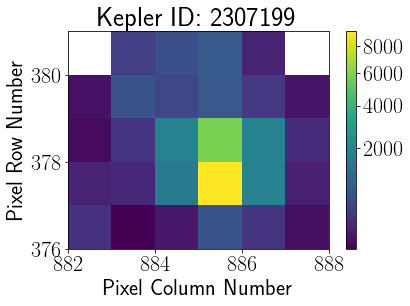

In [9]:
tpf.plot(frame=157, scale='sqrt')

In [10]:
lc = tpf.to_lightcurve()

In [11]:
bkg_lc = tpf.get_bkg_lightcurve(method='kepler_pipeline')

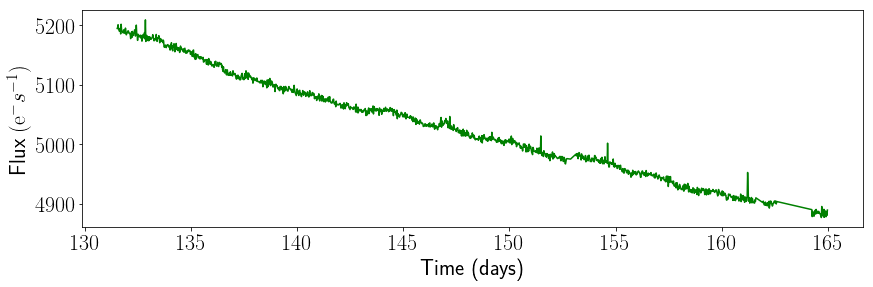

In [12]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, bkg_lc, color='green')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

In [13]:
aper_flux = lc.flux + bkg_lc

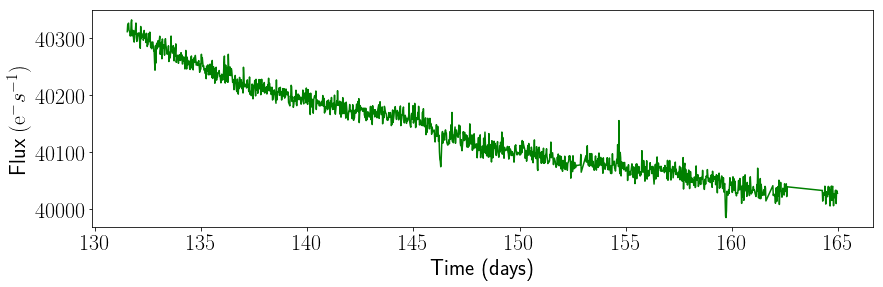

In [14]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, aper_flux, color='green')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

In [15]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [16]:
from oktopus.prior import UniformPrior

In [17]:
prior = UniformPrior(lb=[4e3, 884, 376, 10],
                     ub=[50e3, 887, 380, 1e3])

In [18]:
from pyke.prf import SceneModel

In [19]:
scene = SceneModel(prfs=[prf])

In [20]:
phot_poisson = PRFPhotometry(scene_model=scene, prior=prior)

In [21]:
results = phot_poisson.fit(tpf_flux=(tpf.flux + tpf.flux_bkg))

100%|██████████| 1425/1425 [00:53<00:00, 26.87it/s]


In [22]:
flux = results[:, 0]
xcenter = results[:, 1]
ycenter = results[:, 2]
bkg = results[:, 3]

In [23]:
total_flux = flux + bkg * tpf.aperture_npix

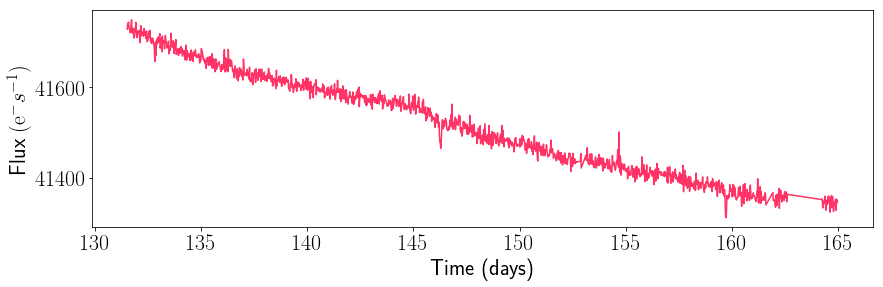

In [24]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, total_flux, color='#ff3366')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

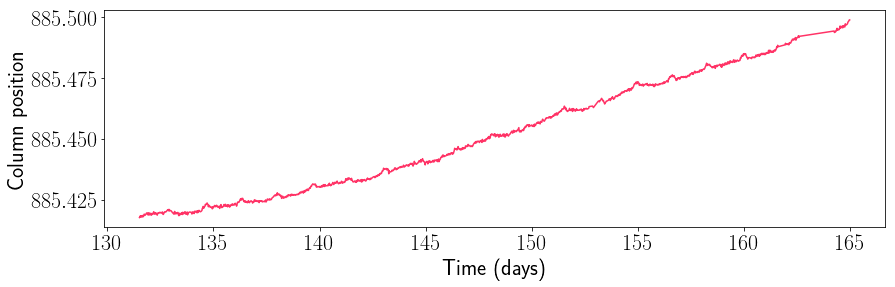

In [25]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, xcenter, color='#ff3366')
plt.ylabel('Column position')
plt.xlabel('Time (days)')

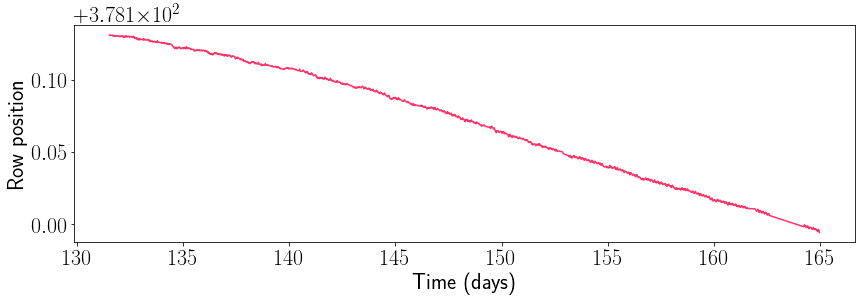

In [26]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, ycenter, color='#ff3366')
plt.ylabel('Row position')
plt.xlabel('Time (days)')

In [27]:
residuals_poisson = phot_poisson.residuals

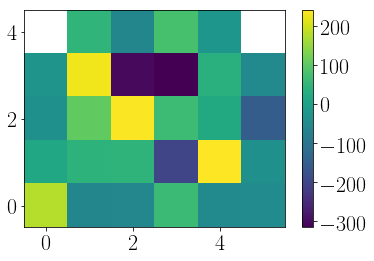

In [44]:
plt.imshow(residuals_poisson[-1], origin='lower')
plt.colorbar()

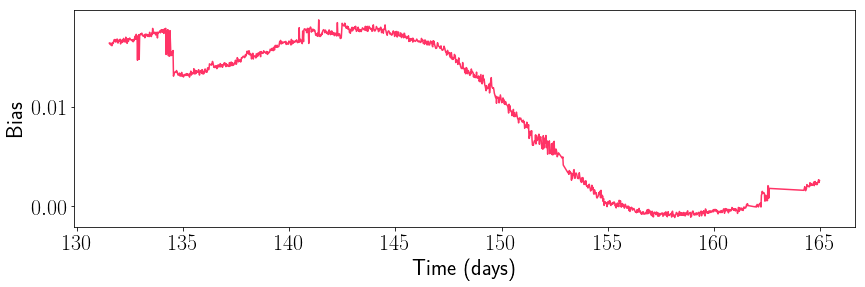

In [32]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, np.nanmean(residuals_poisson, axis=(1,2)), color='#ff3366')
plt.ylabel('Bias')
plt.xlabel('Time (days)')

In [33]:
from oktopus import GaussianPosterior
import tqdm

In [34]:
opt_params = np.array([])
residuals = np.array([])
uncertainties = np.array([])
for i in tqdm.tqdm(range(0, tpf.flux.shape[0])):
    loss = GaussianPosterior(data=tpf.flux[i] + tpf.flux_bkg[i], mean=scene,
                             var=tpf.flux[i] + tpf.flux_bkg[i], prior=prior)
    result = loss.fit(x0=prior.mean, method='powell')
    opt_params = np.append(opt_params, result.x)
    residuals = np.append(residuals, tpf.flux[i] + tpf.flux_bkg[i] - scene(*result.x))
    uncertainties = np.append(uncertainties, loss.loglikelihood.uncertainties(result.x))
opt_params = opt_params.reshape((tpf.flux.shape[0], 4))
residuals = residuals.reshape(tpf.flux.shape)

100%|██████████| 1425/1425 [01:48<00:00, 10.70it/s]


In [35]:
uncertainties = uncertainties.reshape((tpf.flux.shape[0], 4))

In [36]:
flux_gauss = opt_params[:, 0]
xcenter_gauss = opt_params[:, 1]
ycenter_gauss = opt_params[:, 2]
bkg_gauss = opt_params[:, 3]

In [37]:
total_flux_gauss = flux_gauss + bkg_gauss * tpf.aperture_npix

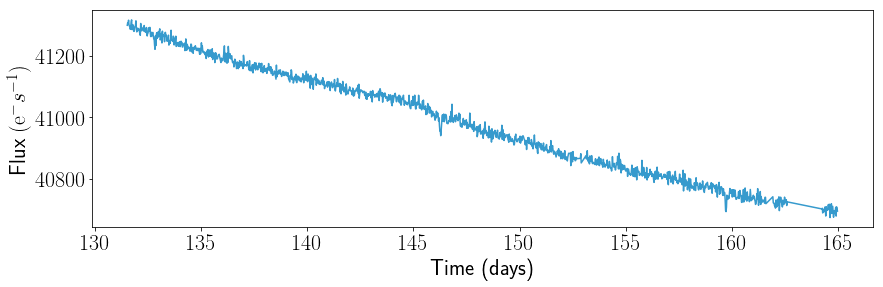

In [38]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, total_flux_gauss, color='#369acd')
plt.ylabel('Flux $(\mathrm{e}^{-}s^{-1})$')
plt.xlabel('Time (days)')

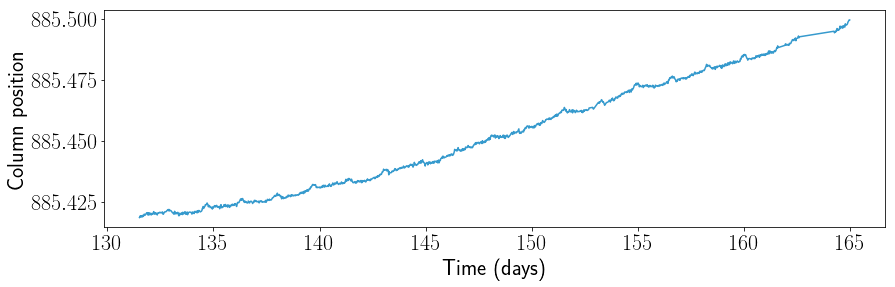

In [39]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, xcenter_gauss, color='#369acd')
plt.ylabel('Column position')
plt.xlabel('Time (days)')

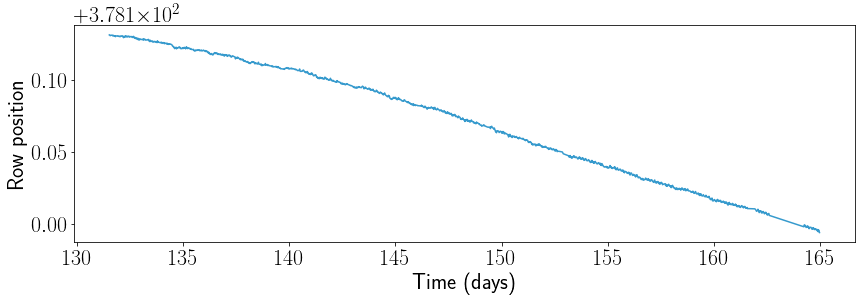

In [40]:
plt.figure(figsize=[14, 4])
plt.plot(lc.time, ycenter_gauss, color='#369acd')
plt.ylabel('Row position')
plt.xlabel('Time (days)')

In [49]:
np.nanmedian(residuals[-1])

15.93851933106572

In [58]:
np.nanmedian(residuals_poisson[-1])

-3.5130197193943786

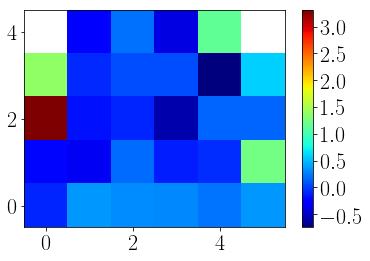

In [57]:
i=157
plt.imshow(np.log(residuals_poisson[i]/residuals[i]), origin='lower', cmap='jet')
plt.colorbar()

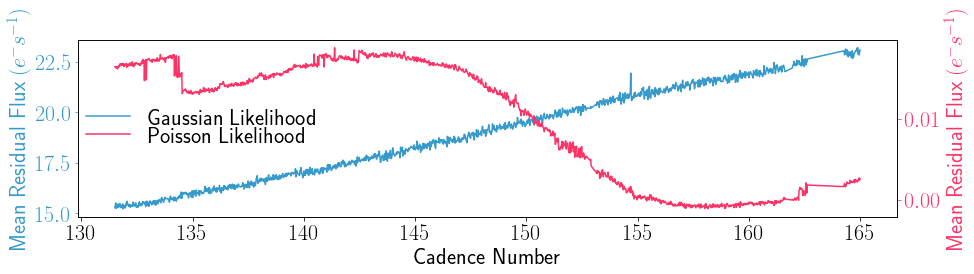

In [42]:
fig, ax1 = plt.subplots(figsize=[14, 4])
ax1.plot(tpf.time, np.nanmean(residuals, axis=(1, 2)), color='#369acd', label='Gaussian Likelihood')
ax1.set_xlabel('Cadence Number')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$', color='#369acd')
ax1.tick_params('y', colors='#369acd')
plt.legend(loc=(0,.45), frameon=False)

ax2 = ax1.twinx()
ax2.plot(tpf.time, np.nanmean(residuals_poisson, axis=(1, 2)), color='#ff3366', label='Poisson Likelihood')
ax2.set_ylabel('Mean Residual Flux $(e^{-}s^{-1})$', color='#ff3366')
ax2.tick_params('y', colors='#ff3366')
plt.legend(loc=(0,.35), frameon=False)
plt.tight_layout()

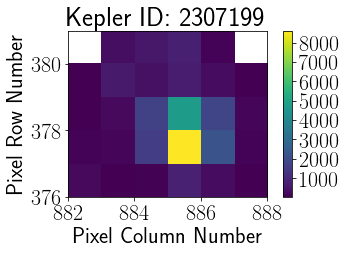

In [43]:
tpf.plot(cadenceno=2000)
plt.tight_layout()